# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        _ = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1000)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_acc = np.mean(y_train_pred == y_train)
        val_acc = np.mean(y_val_pred == y_val)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-09 reg 1.000000e+05 train accuracy: 0.094020 val accuracy: 0.078000
lr 1.000000e-09 reg 1.000000e+06 train accuracy: 0.103245 val accuracy: 0.124000
lr 1.000000e-09 reg 1.000000e+07 train accuracy: 0.313878 val accuracy: 0.306000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.085184 val accuracy: 0.077000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.408714 val accuracy: 0.411000
lr 1.000000e-08 reg 1.000000e+07 train accuracy: 0.412531 val accuracy: 0.425000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.415837 val accuracy: 0.420000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.401429 val accuracy: 0.388000
lr 1.000000e-07 reg 1.000000e+07 train accuracy: 0.300673 val accuracy: 0.305000
best validation accuracy achieved during cross-validation: 0.425000


In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.401


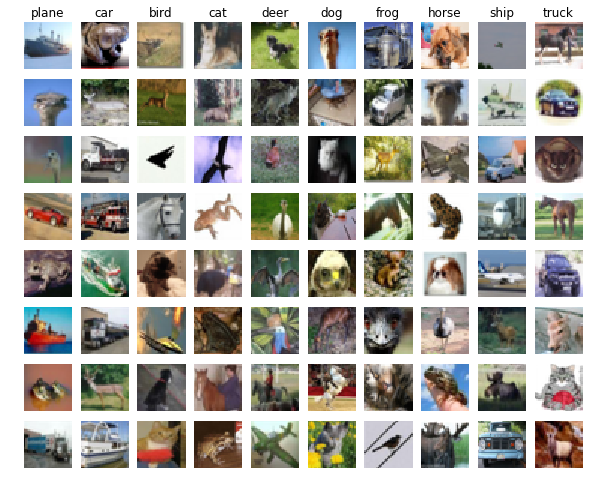

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense? *Some of them. For example a lot of animals like cats and dogs are mixed up are mixed up and some birds have been mistaken for aeroplanes. But there are also many others that don't make much sense, cat mistaken for truck for example.*

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
print X_train_feats.shape

(49000L, 155L)


In [28]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
results = {}
best_val = -1
learning_rates = [1] #np.logspace(-10, 0, 5)
regularisation_strengths = [0.001] #np.logspace(-3, 5, 5)
iters = 2000
for lr in learning_rates:
    for reg in regularisation_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        _ = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=iters, batch_size=200,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg=reg, verbose=False)
        val_acc = np.mean(net.predict(X_val_feats) == y_val)
        results[(lr, reg)] = val_acc
        print 'learning rate: %f, regularisation strength: %f, validation accuracy: %f' % (lr, reg, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

learning rate: 1.000000, regularisation strength: 0.001000, validation accuracy: 0.590000


In [29]:
best_params = sorted(results.items(), key=lambda x: x[1])[-1][0]
print 'Best validation accuracy of %f with learning rate %f and regularisation strength %f' % (
    best_val, best_params[0], best_params[1])

Best validation accuracy of 0.590000 with learning rate 1.000000 and regularisation strength 0.001000


In [30]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.57


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

## We will use a neural network to extract features from the images

In [36]:
# load data

from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000L, 3072L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 3072L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 3072L)
Test labels shape:  (1000L,)


In [37]:
# train network

input_size = 32 * 32 * 3
hidden_size = 200
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
lr = 1e-3
reg = 0.5
iters = 2000
_ = net.train(X_train, y_train, X_val, y_val,
            num_iters=iters, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc

iteration 0 / 2000: loss 2.304097
iteration 100 / 2000: loss 1.993824
iteration 200 / 2000: loss 1.837453
iteration 300 / 2000: loss 1.620403
iteration 400 / 2000: loss 1.643977
iteration 500 / 2000: loss 1.591955
iteration 600 / 2000: loss 1.575577
iteration 700 / 2000: loss 1.529461
iteration 800 / 2000: loss 1.455210
iteration 900 / 2000: loss 1.568998
iteration 1000 / 2000: loss 1.530738
iteration 1100 / 2000: loss 1.459911
iteration 1200 / 2000: loss 1.346193
iteration 1300 / 2000: loss 1.330717
iteration 1400 / 2000: loss 1.397273
iteration 1500 / 2000: loss 1.394271
iteration 1600 / 2000: loss 1.509993
iteration 1700 / 2000: loss 1.400394
iteration 1800 / 2000: loss 1.581424
iteration 1900 / 2000: loss 1.390560
Validation accuracy:  0.489


In [34]:
# use neural network above to extract features from the images

def extract_activations(net, X):
    '''
    extracts the hidden layer activation from net for each image in X
    '''
    
    # get the network weights
    W1 = net.params['W1']
    b1 = net.params['b1']
    
    # compute activations in hidden layer
    Z1 = X.dot(W1) + b1
    A1 = np.maximum(Z1, 0)
    
    return A1
    

In [42]:
X_train_activations = extract_activations(net, X_train)
X_val_activations = extract_activations(net, X_val)
X_test_activations = extract_activations(net, X_test)

print 'train activations shape:', X_train_activations.shape
print 'val activations shape:', X_val_activations.shape
print 'test activations shape:', X_test_activations.shape

train activations shape: (49000L, 200L)
val activations shape: (1000L, 200L)
test activations shape: (1000L, 200L)


# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

## Train a SVM on the extracted features

In [44]:
learning_rates = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
regularization_strengths = [1e4, 1e5, 1e6, 1e7, 1e8]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        _ = svm.train(X_train_activations, y_train, learning_rate=lr, reg=reg, num_iters=1000)
        y_train_pred = svm.predict(X_train_activations)
        y_val_pred = svm.predict(X_val_activations)
        train_acc = np.mean(y_train_pred == y_train)
        val_acc = np.mean(y_val_pred == y_val)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

cs231n\classifiers\linear_svm.py:111: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
cs231n\classifiers\linear_svm.py:111: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)
cs231n\classifiers\linear_svm.py:155: RuntimeWarning: overflow encountered in multiply
  dW += reg * W


lr 1.000000e-09 reg 1.000000e+04 train accuracy: 0.099367 val accuracy: 0.102000
lr 1.000000e-09 reg 1.000000e+05 train accuracy: 0.092878 val accuracy: 0.103000
lr 1.000000e-09 reg 1.000000e+06 train accuracy: 0.099571 val accuracy: 0.114000
lr 1.000000e-09 reg 1.000000e+07 train accuracy: 0.363612 val accuracy: 0.366000
lr 1.000000e-09 reg 1.000000e+08 train accuracy: 0.341633 val accuracy: 0.357000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.139694 val accuracy: 0.149000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.130939 val accuracy: 0.139000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.333653 val accuracy: 0.335000
lr 1.000000e-08 reg 1.000000e+07 train accuracy: 0.343653 val accuracy: 0.347000
lr 1.000000e-08 reg 1.000000e+08 train accuracy: 0.276469 val accuracy: 0.282000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.305796 val accuracy: 0.316000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.352224 val accuracy: 0.359000
lr 1.000000e-07 reg 1.000000

cs231n\classifiers\linear_svm.py:102: RuntimeWarning: invalid value encountered in less
  margins[margins < 0] = 0
cs231n\classifiers\linear_svm.py:129: RuntimeWarning: invalid value encountered in greater
  gt_margin = margins > 0
cs231n\classifiers\linear_classifier.py:68: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad
